# SURE-based Automatic Parameter Selection For ESPIRiT Calibration
Siddharth Iyer, Frank Ong, Kawin Setsompop, Mariya Doneva, and Michael Lustig, 2020

## ESPIRiT
### An Eigenvalue Approach to Autocalibrating  Parallel MRI
#### by Martin Uecker et al.

In [1]:
using Images

### Theory
#### Sense

Reconstruction as a linear inverse problem with the image x to be reconstructed and the sensitivity map $S_i$ with respect to the *i* th coil,
<br>
<br>
$$y_i = \mathcal{P}\mathcal{F}\mathcal{S}_i x \quad | \quad 1 \leq i \leq N \tag{1}$$

,where $y_i$ is the received signal, which is represented by the fourier operator $\mathcal{F}$ and operator $\mathcal{P}$, which chooses only the aquired k-space locations. 

#### GRAPPA

$$x_i(r) = (P_r R_r y) ^T g_{ri} \tag{2}$$
<br>
- $R_r$ operator choosing block of k-space from all coils at postion *r*
- $P_r$ represent local sampling pattern that choose only aquired samples
- $g_{ri}$ GRAPPA weights, or kernel weights
- $y$ multicoil k-space grid concatenated into a vector and 0 filled missing data


#### Reconstruction Weights

Calibration matrix A is constructed by a sliding window over the fully sampled autocalibration (AC) signal

- calibration matrix A
- $(R_r y)^T$ inside AC is a row in A
yields the following weight conditions:
$$ y_i^{AC} = AP_r^T g_{ri} \tag{3}$$

, where $y_i$ is the data from the *i*th coil inside the AC region. <br>
The weights, which approximately solve this equation are computed by solving a regularized least squares problem.

By construction, one of the columns of $A$ is $y_i^{AC}$. Hence, we cen write $Ae_i = y_i^{AC}$, where e_i is a canonical basis vector with a "1" at the appropriate position.

$$\begin{align}
0   &= AP_r^T g_{ri} - y_i^{AC} \tag{4}\\
    &= AP_r^T gr_{ri} - Ae_i \\
    &= A(P_r^T g_{ri} - e_i) 
   \end{align} $$
<br>
This result shows that $(P_r^T g_{ri} - e_i)$ lies in the nullspace of A. Therefore, we have redundancy in A.

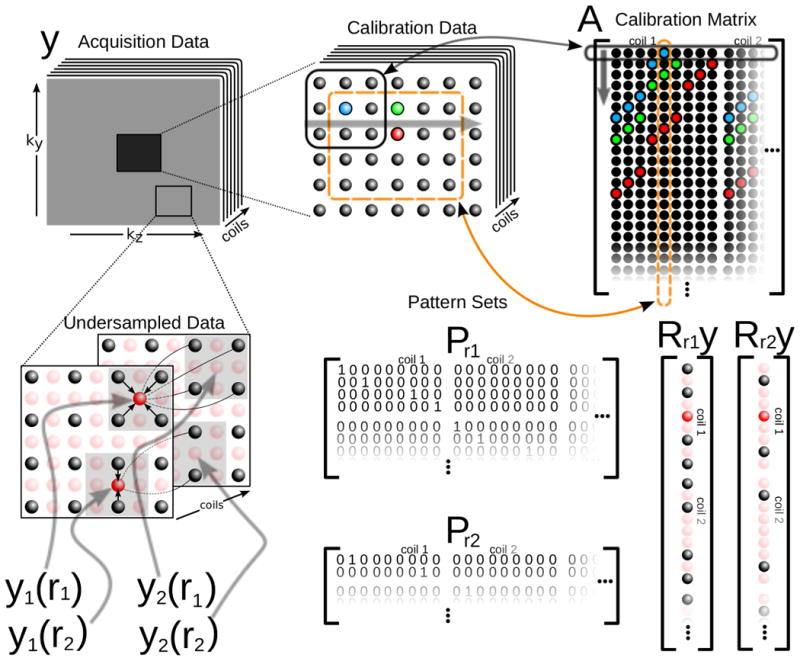

In [2]:
load("Fig1.jpg")

### Calibration Matrix and Null-Space Reconstruction

SVD of A:
$$ A = U \Sigma V^H$$
<br>
Where the first k columns ${v_1,...,v_k}$ of V (rows of $V^H$) form an orthonormal basis of the row space of A and <br>
the last columns of V (rows of $V^H$) form an orthonormal basis of the null space of A. 
<br>
Thus, we define $V_{\parallel}$ which spans the row space and $V_{\bot}$ which spans the null space.
<br>
**Fundamental Theorem of Linear Algebra**

In [1]:
load("Fig2.jpg")

UndefVarError: UndefVarError: load not defined

This information leads to the following two constraints:

$$\begin{align}
V_{\parallel}V_{\parallel}^H R_r x &= R_r x \quad | \quad \forall r \tag{5a}\\
V_{\bot}^H R_r x &= 0  \quad | \quad \forall r \tag{5b}\\
P_r R_r x &= P_r R_r y \quad | \quad \forall r \tag{6}
\end{align}$$

Equations 5a and 5b are consistency with calibration and Eq. 6 is consistency with the data aquisition.

Multiplying Equation 5a with $R^H$ from the left and summing over *r*, Eq. 5a can be reformulated to <br> <br>
$$ \underbrace{M^{-1} \sum_{r} R_r^H V_{\parallel} V_{\parallel}^H R_r}_{\mathcal{W}} x = x , \tag{7}$$
where $M$ represent $\sum_{r} R_r^H R_r$and equals the number of samples in each patch.

Rewriting the two constraints yields
$$\begin{align}
\mathcal{W}x &= x \tag{8a}\\
\mathcal{P}x &= \mathcal{P}y, \tag{8b}
\end{align}$$
where $\mathcal{P}$ is again the operator selecting the aquired samples of the full grid.

### Sensitivity Maps as an Eigenvalue Problem
Eigenvalue Equation
$$ Av = \lambda v$$

Reconstruction $x$ must satisfy $Wx = x$, thus $x$ belongs to the subspace spanned by the eigenvectors of $W$ corresponding to the eigenvalue "1".

Now writing $x$ in terms of the k-space of the original image weighted by the coil sensitivities, we get
<br>
<br>
$$ x = \mathcal{F}\mathcal{S}m, \tag{9}$$
<br>
where $S=[S_1 S_2 ... S_N]^T$ is a vector of stacked coil sensitivities.
<br>
<br>
Assuming this is indeed a solution yields
$$ \mathcal{W}\mathcal{F}\mathcal{S}m = \mathcal{F}\mathcal{S}m \tag{10}.$$


Now, applying the inverse Fourier transform on both sides, shows that the vector of coil images $\mathcal{S}m$ is an eigenvector of $\mathcal{F}^{-1}\mathcal{W}\mathcal{F}$ with eigenvalue "1":
$$\mathcal{F}^{-1}\mathcal{W}\mathcal{F}\mathcal{S}m = \mathcal{S}m \tag{11}$$
<br>
If we  perform the eigenvalue decomposition on $\mathcal{W}$ we should be able to get the sensitivities explicitly.

Since, $\mathcal{W}$ is a positive semidefinite matrixvalued convolution in k-space, it can be decoupled as a point-wise positive semidefinite matrix operation in the image domain:
$$\mathcal{F}^{-1}\mathcal{W}\mathcal{F}|_q = \mathcal{G}_q, \tag{12}$$
at point *q*.

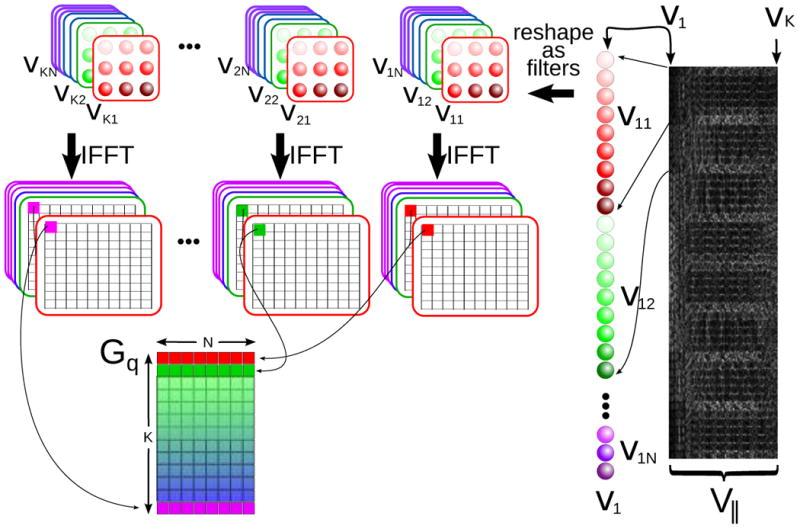

In [4]:
load("Fig3.jpg")

$\mathcal{G}_q = G_q^H G_q$

The sensitivity maps are found by the eigenvalue decomposition of all $\mathcal{G}_q$'s choosing only the eigenvectors with corresponding eigenvalue "1". At positions, where no eigenvalue "=1" was found, the sensitivities are set to zero. <br>
For one eigenvalue "=1" at each position, the eigenvectors are the solution to the SENSE reconstruction problem.

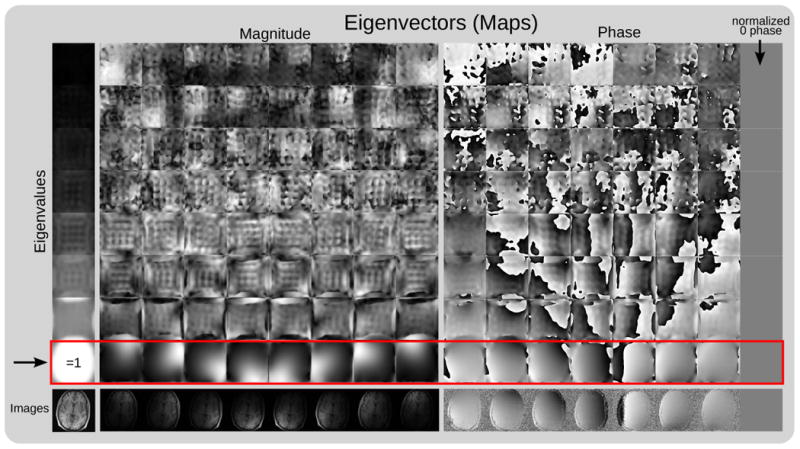

In [5]:
load("Fig4.jpg")

### Implementation using Soft SENSE

Errors in the aquisition data may lead to additional eigenvectors with eigenvalue "1" and different sets of sensitivity maps $S^j$:
<br>
<br>
$$ y_i = \mathcal{P}\mathcal{F} \sum_{j=1}^{M} \mathcal{S}_i^j m^j, \tag{13}$$
<br>
which is a reformulation of Equation 1 for multiple image components and sensitivity maps called "soft SENSE".

This problem can be formulated as the optimization of a functional:
$$ J(m^1,...,m^M) = \sum_{i=1}^{N}||y_i - \mathcal{P}\mathcal{F} \sum_{j=1}^{M}S_i^j x^j||_2^2 + \alpha \sum_{j=1}^{M}Q(x^j), \tag{14}$$

where Q is the regularization term and can be replaced by the $\mathcal{l}_1$ norm with a wavelet transform $\Phi$, using $Q(m)= ||\Phi m||_1^2$ for example. The reformulation yields $\mathcal{l}_1-ESPIRiT$, which is useful for compressed sensing reconstruction of randomly undersampled data.

In [54]:
using MAT
using FFTW
using PyPlot
using LinearAlgebra
using Augmentor
using PyCall
sigpy = pyimport("sigpy.mri")
sigpyapp = pyimport("sigpy.app")

PyObject <module 'sigpy.app' from '/home/julius/.local/lib/python3.8/site-packages/sigpy/app.py'>

In [3]:
fft2c(im) = fftshift(fft(fftshift(im))); #centered 2D fourier transform

function zpad(x, sx,sy,sz) # zero padding around the center of a 3D matrix
    s = [sx,sy,sz];
    m = size(x)
    if length(m) < length(s)
        m = [m, ones(1,length(s)-length(m))];
    end
    
    if sum(m==s)==length(m)
        res = x;
        return res;
    end

    res = zeros(ComplexF64,sx,sy,sz);

    res[115-2:115+3, 90-2:90+3,:] = x;
    return res;
    end

zpad (generic function with 1 method)

In [4]:
function im2row(im, winSize)
#res = im2row(im, winSize)
sx,sy,sz = size(im);

res = zeros(ComplexF64,(sx-winSize[1]+1)*(sy-winSize[2]+1),prod(winSize),sz);
count=0;
for y=1:winSize[2]
    for x=1:winSize[1]
        count = count+1;
        res[:,count,:] = reshape(im[x:sx-winSize[1]+x,y:sy-winSize[2]+y,:],(sx-winSize[1]+1)*(sy-winSize[2]+1),1,sz);
    end
end
    return res
end

im2row (generic function with 1 method)

In [5]:
function dat2Kernel(data, kSize)
#Function to perform k-space calibration step for ESPIRiT and create
# k-space kernels. Only works for 2D multi-coil images for now.  
# 
# Inputs: 
#       data - calibration data [kx,ky,coils]
#       kSize - size of kernel (for example kSize=[6,6])
#
# Outputs: 
#       kernel - k-space kernels matrix (not cropped), which correspond to
#                the basis vectors of overlapping blocks in k-space
#       S      - (Optional parameter) The singular vectors of the
#                 calibration matrix
    sx,sy,nc = size(data);
    imSize = [sx,sy] ;

    tmp = im2row(data,kSize); 
    tsx,tsy,tsz = size(tmp);
    A = reshape(tmp,tsx,tsy*tsz);

    U,S,V = svd(A);

    kernel = reshape(V,kSize[1],kSize[2],nc,size(V,2));
    
    return kernel, S
end

dat2Kernel (generic function with 1 method)

In [6]:
function ifft2c(x) #inverse centered 2D fourier transform

    S = size(x);
    fctr = S[1]*S[2];

        x = reshape(x,S[1],S[2],prod(S[3:end]));

    res = zeros(ComplexF64, size(x));
    for n=1:size(x,3)
    res[:,:,n] = sqrt(fctr)*fftshift(ifft(ifftshift(x[:,:,n])));
    end


    res = reshape(res,S);
        return res
end

ifft2c (generic function with 1 method)

In [7]:
mri_data = matread("brain.mat");
kspace = mri_data["ksp"]

### Individual Coil Images

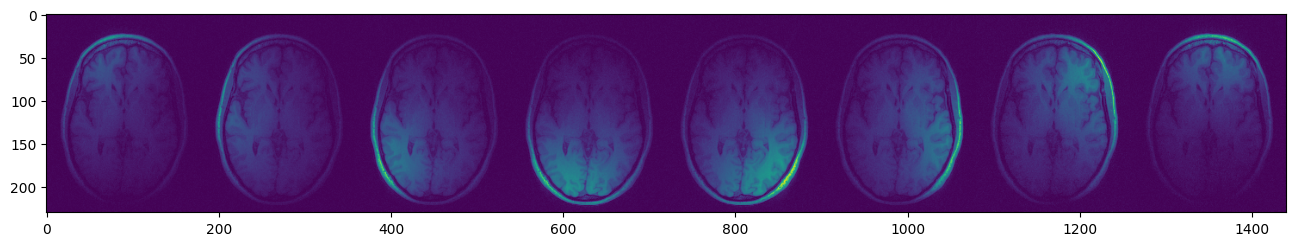

(230, 180, 8)

PyObject <matplotlib.image.AxesImage object at 0x7f456aef4880>

In [79]:
image = ifft2c(kspace)
print(size(image))
imagedisp = reshape(image, (230, 180*8))
fig = figure(figsize=(16,16))
imshow(abs.(imagedisp[:,:]));

In [92]:
sx,sy,Nc = size(kspace);
ncalib = 24; # use 24 calibration lines to compute compression
ksize = [6,6]; # kernel size
# Threshold for picking singular vercors of the calibration matrix
# (relative to largest singlular value.

eigThresh_1 = 0.02;

#threshold of eigen vector decomposition in image space.
eigThresh_2 = 0.8;

#crop a calibration area
calib = augment(kspace, CropSize(ncalib, ncalib, Nc));
#calib2 = kspace[115-11:115+12, 90-11:90+12,:]; # FYI how the cropping works, calib == calib2

In [14]:
k,S = dat2Kernel(calib,ksize);

### Define the autocalibration Matrix and compute the svd

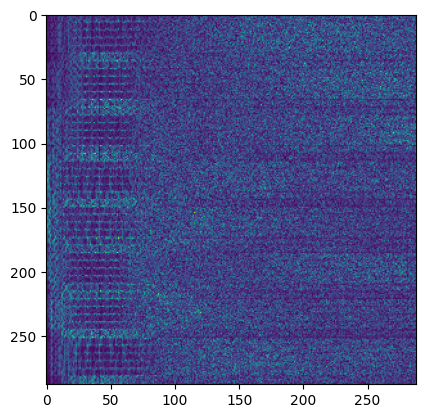

PyObject <matplotlib.image.AxesImage object at 0x7f457328c640>

In [17]:
kdisp = reshape(k, (ksize[1]*ksize[2]*Nc,ksize[1]*ksize[2]*Nc))
imshow(abs.(kdisp))

In [18]:
biggest_sigmas = S[S .>= S[1] *eigThresh_1]
idx = size(biggest_sigmas, 1)
print(idx)

61

### Threshold the singular values to separate V into **$V_{\parallel}$** and **$V_{\bot}$**

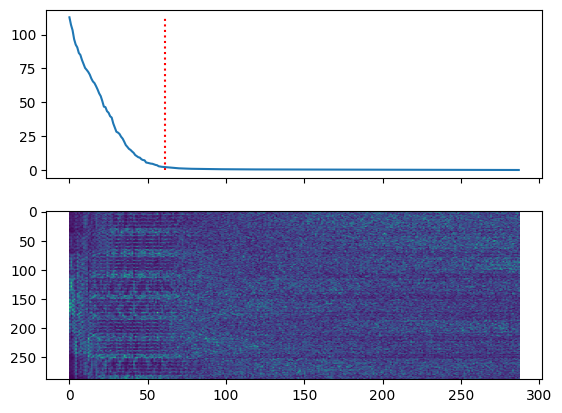

In [19]:
fig, (ax1, ax2) = subplots(2,1, sharex = true)
ax1.plot(S)
ax1.vlines(idx, 0,S[1], color="red", linestyles="dotted")
ax2.imshow(abs.(kdisp), aspect ="auto");

In [180]:
function kernelEig(kernel, imSize)
# INPUTS:
#           kernel - k-space kernels computed with dat2Kernel (4D)
#           imSize - The size of the image to compute maps for [sx,sy]
#
# OUTPUTS:
#           EigenVecs - Images representing the Eigenvectors. (sx,sy,Num coils,Num coils)
#           EigenVals - Images representing the EigenValues. (sx,sy,numcoils )
#                       The last are the largest (close to 1)
    nc = size(kernel,3);
    nv = size(kernel,4);
    kSize = [size(kernel,1), size(kernel,2)];
    # "rotate kernel to order by maximum variance"
    k = permutedims(kernel,[1,2,4,3]);

    k =reshape(k,(kSize[1]*kSize[2]*nv,nc));
  
    u,s,v = svd(k);

    
    k = k*v;

    kernel = reshape(k,(kSize[1], kSize[2],nv,nc)); 

    kernel = permutedims(kernel,[1,2,4,3]);
    KERNEL = zeros(ComplexF64,imSize[1], imSize[2],  size(kernel,3), size(kernel,4)); #compute kernel in image space
    
    for n=1:size(kernel,4)
        KERNEL[:,:,:,n] = fft2c(zpad(conj(kernel[end:-1:1,end:-1:1,:,n])*sqrt(imSize[1]*imSize[2]),
                imSize[1], imSize[2], size(kernel,3))); 
    end
    KERNEL = KERNEL./sqrt(prod(kSize));

    EigenVecs = zeros(ComplexF64, imSize[1], imSize[2], nc, min(nc,nv));
    EigenVals = zeros( imSize[1], imSize[2], min(nc,nv));
    
    i2s = CartesianIndices((1:imSize[1],1:imSize[2]));
    for n=1:prod(imSize)
    
        ind = i2s[n]

        mtx = KERNEL[ind,:,:]

        #[C,D] = eig(mtx*mtx');
        C,D,V = svd(mtx);
        
        ph = exp.(-1im*angle.(C[1,:]));
        ph = repeat(ph', 8)
        C = v*(C.*ph);
        D  = real.(D)
        EigenVals[ind,:] = D[end:-1:1];
        EigenVecs[ind,:,:] = C[:,end:-1:1];
    end
    return EigenVecs, EigenVals
end

kernelEig (generic function with 1 method)

In [183]:
M,W = kernelEig(k[:,:,:,1:idx],[sx,sy]);
max, max_idx = findmax(W)
W = W./max;

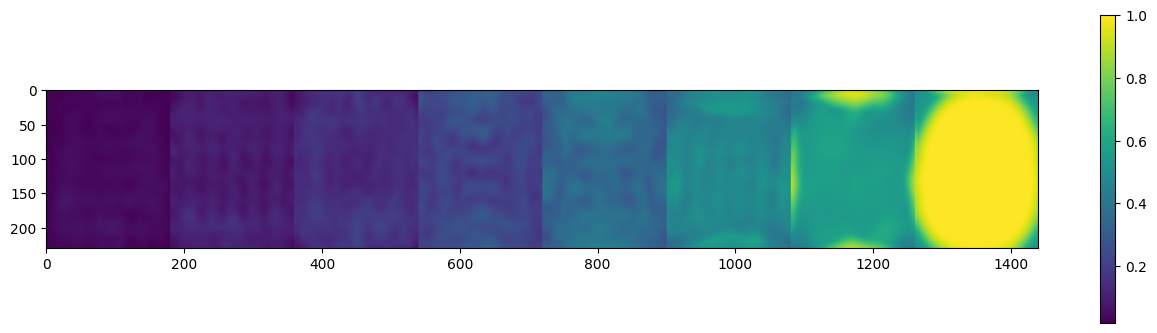

PyObject <matplotlib.colorbar.Colorbar object at 0x7f456e4344c0>

In [185]:
Wdisp = reshape(W, (size(W,1), size(W,2)*size(W,3)));
fig, ax = subplots(figsize=(16,4))
mappable = ax.imshow(abs.(Wdisp));
colorbar(mappable, ax=ax)

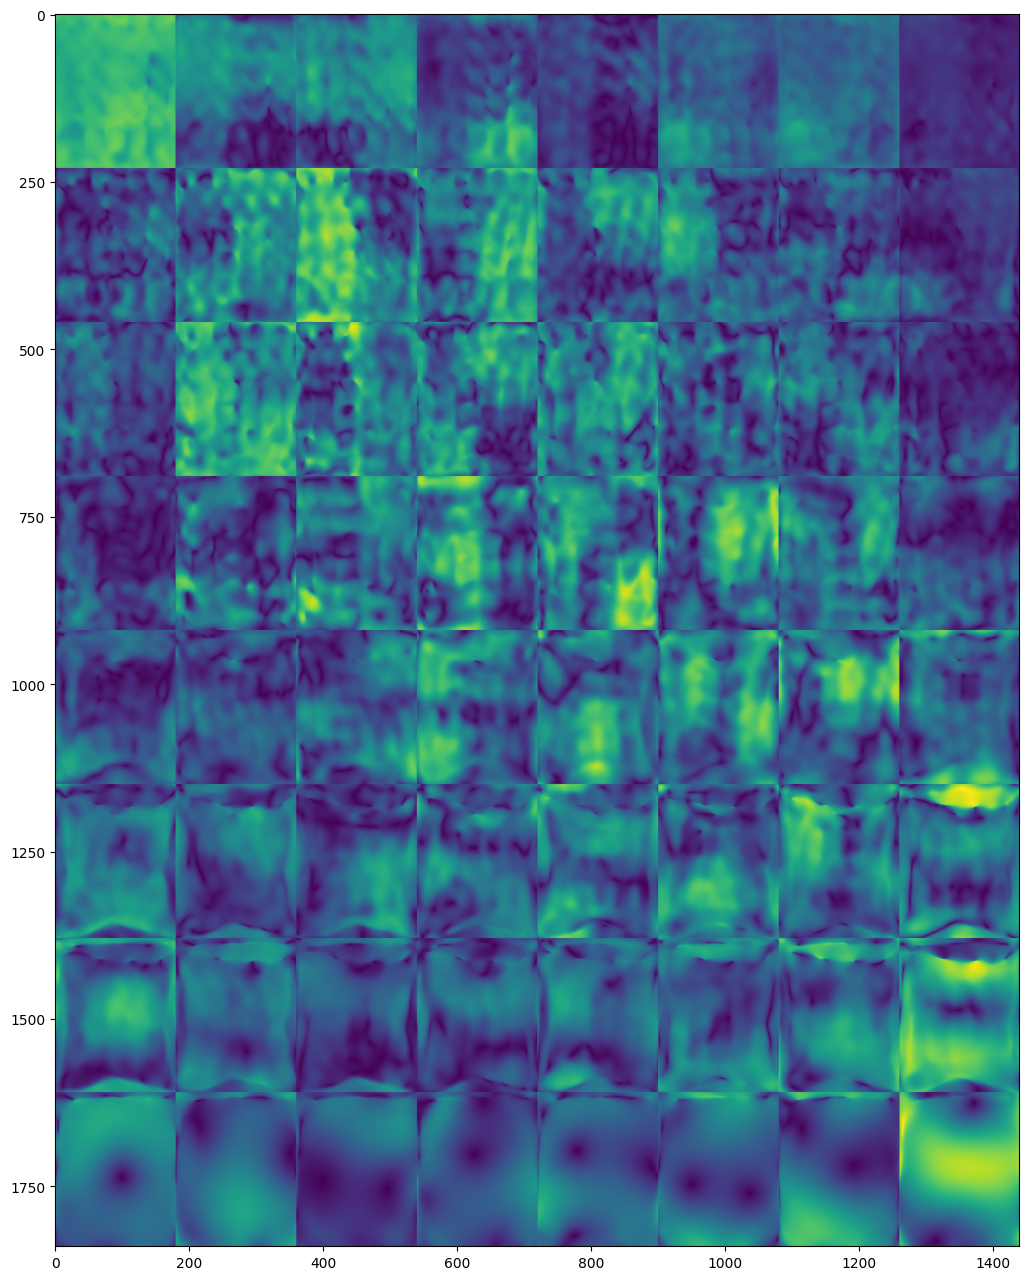

PyObject <matplotlib.image.AxesImage object at 0x7f456e0528e0>

In [208]:
Mdisp = vcat([M[:,:,:,i] for i=1:Nc]...);
Mdisp = reshape(Mdisp, (size(Mdisp,1), size(Mdisp,2)*size(Mdisp,3)));
fig = figure(figsize=(16,16))
imshow(abs.(Mdisp))

In [186]:
@show size(M[:,:,:,end])
W_thresh2 = abs.(W[:,:,end]).>eigThresh_2
#maps = M[:,:,:,end]; #the last entry are the sensitivity maps, see paper
maps = M[:,:,:,end].*repeat(abs.(W[:,:,end]).>eigThresh_2,outer=(1,1,Nc));
recon_weights = repeat(W[:,:,end], outer=(1,1,Nc));

size(M[:, :, :, end]) = (230, 180, 8)


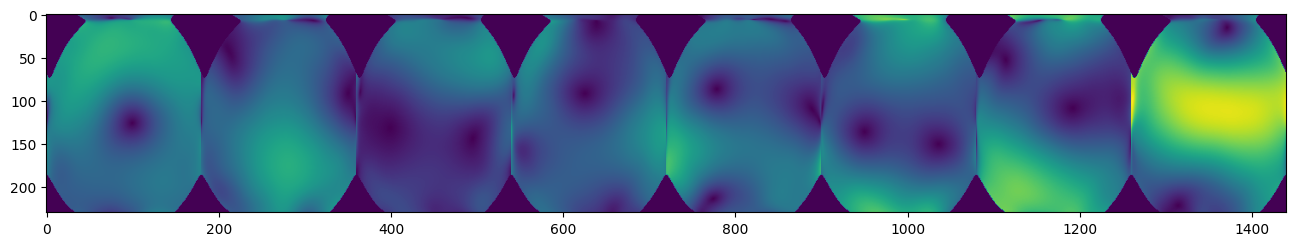

PyObject <matplotlib.image.AxesImage object at 0x7f456e400ac0>

In [187]:
dispMaps = reshape(maps, size(maps,1), size(maps,2)*Nc)
fig = figure(figsize=(16,16))
imshow(abs.(dispMaps[:,:]))

### SENSE Reconstruction

In [188]:
#sigpy SENSE reconstruction
weights = sigpy.app._estimate_weights(kspace, recon_weights, coord= nothing)
A = sigpy.linop.Sense(mps=maps, weights= weights, ishape=(230,180,8))
recon = sigpyapp.LinearLeastSquares(A, kspace, lamda=0.02, show_pbar=true).run();


/usr/lib/python3.8/inspect.py:350: MatplotlibDeprecationWarning: 
The aname attribute was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  value = getattr(object, key)
/usr/lib/python3.8/inspect.py:350: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  value = getattr(object, key)
/usr/lib/python3.8/inspect.py:350: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  value = getattr(object, key)
LinearLeastSquares: 100%|████| 100/100 [00:06<00:00, 15.45it/s, resid=7.26E-14]

In [189]:
opt_recon = sqrt.(sqrt.(sum(abs.(image), dims=3).^2));
recon = sqrt.(sqrt.(sum(abs.(recon), dims=3).^2));

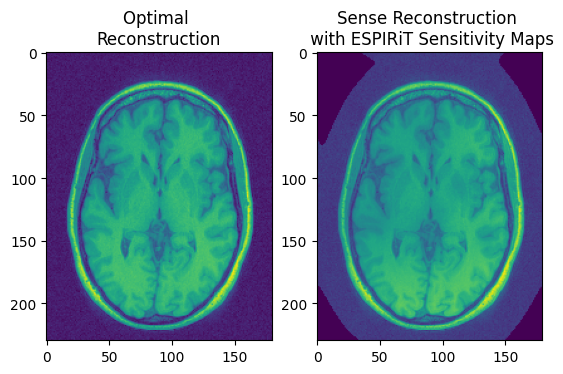

(230, 180, 1)

PyObject Text(0.5, 1.0, 'Sense Reconstruction \n with ESPIRiT Sensitivity Maps')

In [195]:
print(size(recon))
fig, (ax1, ax2) = subplots(1,2)
ax1.imshow(opt_recon[:,:]);
ax1.set_title("Optimal \n Reconstruction")
ax2.imshow(abs.(recon[:,:]))
ax2.set_title("Sense Reconstruction \n with ESPIRiT Sensitivity Maps")

### Parameter choices in ESPIRiT

- kernel size
- signal Threshhold (eig_thresh_1)
- eigenvalue threshold (eig_thresh_2)

**Denoted as**

- kernel size (k)
- subspace size (w)
- eiigenvalue crop threshold (c)

## Stein's Unbiased Risk Estimator (SURE)
Stein's Unbiased Risk Estimator (SURE) is an unbiased estimator of the MSE of an estimator. This allows one to calculate the MSE of an estimator without knowing the ground truth. 

For the following, let:
   * $x \in \mathbb{C}^m$ be the ground truth to be estimated
   * $n$ be zero-mean, additive Gaussian complex noise
       * $\sigma$ standard deviation
       * Uncorrelated between channels
   * $x_{acq} = x + n$ be the acquired data, used to estimate $x$
   * $h(x_{acq})$ is an estimator of $x$ based on $x_{acq}$
       * Must be representable as $h(x_{acq}) = x_{acq} + g(x_{acq})$
           * $g(x_{acq})$ is weakly differentiable 
                
                
### SURE Formulation
SURE can be formulated as

$$MSE[h] = E_x[SURE(h)]$$

Where SURE has two similar formulations:

$$SURE(h) = m\sigma^2 + ||g(x_{acq})||_2^2 + 2\sigma^2\sum_{i=1}^m \frac{\partial}{\partial x_{acq,i}} g_i(x_{acq})$$

$$SURE(h) = -m\sigma^2 + ||g(x_{acq})||_2^2 + 2\sigma^2\sum_{i=1}^m \frac{\partial}{\partial x_{acq,i}} h_i(x_{acq})$$

### SURE Derivation
These SURE expressions can be derived as:

$$MSE[h] = E_x||h(x_{acq}) - x||_2^2$$

$$MSE[h] = E_x||x_{acq} + g(x_{acq}) - x||_2^2$$

$$MSE[h] = E_x||g(x_{acq}) + (x_{acq} - x)||_2^2$$

$$MSE[h] = E_x||g(x_{acq})||_2^2 + E_x||x_{acq} - x||_2^2 + 2E_x[g(x_{acq})^T(x_{acq}-x)]$$

$$MSE[h] = E_x||g(x_{acq})||_2^2 + m\sigma^2 + 2E_x[g(x_{acq})^T(x_{acq}-x)]$$


The third term, $E_x[g(x_{acq})^T(x_{acq}-x)]$, can be further evaluated as:

$= \int_{\mathbb{C}^m}\frac{1}{\sqrt{2\pi\sigma^{2m}}}\exp(-\frac{||x_{acq}-x||_2^2}{2\sigma^2})\sum_{i=1}^mg_i(x_{acq})(x_{acq,i}-x_i)d^mx_{acq}$

Using integration by parts:

$= \sigma^2\sum_{i=1}^m\int_{\mathbb{C}^m}\frac{1}{\sqrt{2\pi\sigma^{2m}}}\exp(-\frac{||x_{acq}-x||_2^2}{2\sigma^2})\frac{dg_i}{dx_{acq,i}}d^mx_{acq}$

$= \sigma^2\sum_{i=1}^mE_x[\frac{dg_i}{dx_{acq,i}}]$

This result comes from Stein's Lemma 

$$\frac{1}{\sigma^2}\sum_{i=1}^mCov[X_i,f_i(X)] = E[\sum_{i=1}^n\frac{\partial f_i}{\partial x_i}(X)]$$

Substituting this back in:

$$MSE[h] = E_x||g(x_{acq})||_2^2 + m\sigma^2 + 2\sigma^2\sum_{i=1}^mE_x[\frac{dg_i}{dx_{acq,i}}]$$

$$MSE[h] = E_x[||g(x_{acq})||_2^2 + m\sigma^2 + 2\sigma^2\sum_{i=1}^m\frac{dg_i}{dx_{acq,i}}]$$

$$MSE[h] = E_x[SURE(h)]$$

### Alternative notation
To better align with ESPIRiT, a slight change in notation is necessary. Let:
   * $P_{\theta} \in \mathbb{C}^{m \times m}$ be a linear operator parametrised by $\theta$  that estimates $x$ based on $x_acq$
        * Similar to $h(x_{acq})$ from before but without the $h(x_{acq}) = x_{acq} + g(x_{acq})$ constraint
   * $\theta = (k,\omega,c)$
    
This gives the formulation from the paper

$$E[||P_{\theta}x_{acq} - x||_2^2] = E[SURE_{P_{\theta}}(x_{acq})]$$

$$SURE_{P_{\theta}}(x_{acq}) = -m\sigma^2 + ||(P_{\theta}-I)x_{acq}||_2^2 + 2\sigma^2\sum_{i=1}^m \frac{\partial}{\partial x_{acq,i}} P_{\theta}x_{acq}$$

$$SURE_{P_{\theta}}(x_{acq}) = -m\sigma^2 + ||(P_{\theta}-I)x_{acq}||_2^2 + 2\sigma^2[div_{x_{acq,i}} P_{\theta}]x_{acq}$$

$$SURE_{P_{\theta}}(x_{acq}) = -m\sigma^2 + ||(P_{\theta}-I)x_{acq}||_2^2 + 2\sigma^2trace(P_{\theta})$$

### SURE with ESPIRiT

We illustrate the main concepts by considering the non-accelerated, densly-sampled, high-resolution case. 

Let 
- $x_{\text{acq}}$ denote the aquired non-accelerated, densly-sampled, multit-channel images
- $n_c$ denote the number of coils
- $S^i(q)$ denotes the $i$th eigenvector of $\mathcal{G}(q)$ with eigenvalue $\lambda_i(q)$

The eignevector $S^i(q)$ is a $n_c$ dimensional vector and has unit norm. Since $\mathcal{G}(q)$ is Hermitian, the eigenvectors $S^i(q)$ are pairwise orthonormal. The ESPIRiT projecton operator at postion $q$, is deonted by $P(q)$ and defined as

$$
P(q) = \begin{bmatrix}S^1(q) \cdots S^{n_c}(q)\end{bmatrix}\begin{bmatrix}S^1(q) & \cdots & S^{n_c}(q)\end{bmatrix}^\ast
$$

The ESPIRiT projection operator $P$ is represented by stacking the pixel-wise operators diagonally:

$$
P = \begin{bmatrix}
P(1) &   & \Large{0} \\
  & \ddots & \\
\Large{0} &  & P(N)
\end{bmatrix},
$$

where $N$ is the number of image pixels.

We assume that the desired signal lies within the range of the ESPIRiT projection operator. Then, projecting onto this subspace is expected to remove undesired signals such as aditive, white, Gaussian noise that. This interpretation of ESPIRiT as a denoiser allows for the appication of SURE.

Let
- $P_\theta$ be the projection operator derived from a particular ESPIRiT parameter set $\theta = \{k,w,c\}$
- $x$ be the densely-sampled, high resolution, noise-less, multi-channel images
- $I$ be the identity opoerator

In this densesly-sampled, high-resolution case, finding the optimal operator is reduced to finding the optimum $\theta^\ast$ that results in a projection operator $P_\theta^\ast$ that best denoises the input data $x_{acq}$. That is to say, 

$$
\theta^\ast = \arg\!\min_\theta ||x - P_\theta x_\text{acq}||_2^2
$$

Since ESPIRiT is a pixel-wise linear projection operator in the image domain, the divergence contributed by a single pixel $x(q)$ is the trace of the linear operator affecting that pixel (denoted $P_\theta (q)$). Thus, the SURE value of $P_\theta$ can be calculated by summing over all pixel position $q$.

$$SURE_\theta = \sum_q [-n_c \sigma^2 + ||P_\theta(q) - I x_{\text{acq}}||^2_2 + 2 \sigma^2 \text{trace} (P_\theta(q))]$$

This can be used to approximate the minimum mean square error

$$
\theta^\ast = \arg\!\min_\theta||x - P_\theta x_\text{acq}||_2^2 \approx \arg\!\min_\theta SURE_\theta(x_\text{acq})
$$

Since the trace of $AB$ is equal to the trace of $BA$ for any matrix $A,B$, and since $S^i(q)$ are orthonormal to each other, the trace of $P_\theta$ can be efficiently calculated by

$$
\text{trace} P_\theta = \sum_q\sum_i ||S^i(q)||^2
$$

Thus, in the above case, it is possible to search through values of $\theta$ to determine the optimal proection operator $P_\theta$ for calibartion. 

## Accelerated case with the auto-calibration signal
ESPIRiT can be accelerated when the densely sampled region is limited to only the ACS data. For this acceleration, estimate the ESPIRiT operator from only the low-resolution, densely sampled ACS data and enforce data consistency with ACS data k-space using Fourier operator. This leads to a new augmented projection operator: 

$$P_{\theta}^R = RFSS^*F^*R^*$$
Where:
    * $R$ is an operator that outputs an ACS region from densely-sampled k-space

Now that we're working in the k-space, let
    * $y$ be the noise-less, densely-sampled, low-resolution, auto-callibration region in k-space, ground truth to be estimated
    * $n$ again be zero-mean, additive Gaussian complex noise
        * $\sigma$ standard deviation
        * Uncorrelated between channels
    * $y_{acq} = y + n$
    
This leads to a reformulation for the k-space

$$SURE_{P_{\theta}}(y_{acq}) = -m\sigma^2 + ||(P_{\theta}-I)y_{acq}||_2^2 + 2\sigma^2trace(P_{\theta})$$

$$SURE_{P_{\theta}^R}(y_{acq}) = ||(P_{\theta}^R-I)y_{acq}||_2^2 + 2\sigma^2trace(P_{\theta}^R) + C$$

Where:
   * $C$ is some constant which won't affect minimisation
   
Since a change of basis does not affect a matrice's trace, a change of basis can be performed:   

$$trace(P_{\theta}^R) = trace(RFSS^*F^*R^*)  = trace(F^*RFSS^*F^*R^*F)$$

Similar to the original SURE with SPIRiT formulation, this can be expressed as a summation

$$trace(P_{\theta}^R) = \sum_q\sum_i ||\underline{S}^i(q)||_2^2$$

Where:
   * $\underline{S} = F^*RFS$

In this accelerated case, parameter estimatation doesn't necessarily match with the non-accelerated approach in theory, but in practise it often does. 

### Soft-threshold based weighting for the subspace estimation

In practice sweeping through signal subspaces (or the rank of A) is computationally intensive. Thus, a heuristic to appropriately weight the right singular valus based on singular value soft-thresholding as an alternative is presented.

Since we expect the same underlying data through multiple channels, the auto-calibration matrix $A$ is expected to be low rank. However, due to noise and other data inconsistencies present in the data, the observed auto-calibration matrix ofte has full rank. A low-rank approximation of $A$ can then be constructed by hard thresholding the singular values of $A$. Ideally, employing SURE to determine the optimal low-rank approx. in the sense of "denoising" the matrix would be desireable. However, this is difficult to do since a hard threshold is not weakly-differentiable. A common alternative is to soft-treshold the singular values.

Consider the singular value decomposition of $A$

$$
A = \sum_i s_i u_i v_i^\ast
$$

where 
- $u_i$ are the left singular vectors
- $v_i$ are the right singular vectors
- $s_i$ are the singular values.

A soft-threshold low-rank matrix estimate of $A$ denoted by $\hat{A}$, is constructed by soft-thresholding the singluar values by $\lambda$.

$$
\hat{A} = \sum_i (s_i-\lambda)_+ u_iv_i^\ast
$$

If $A$ does not contain strucured noise, it is shown that it is possible to use SURE to efficiently find the optimal $\lambda$, denoted $\lambda^*$ [1]. However, since $A$ is block-Hankel it contains structured noise. Here, we apply the method from [1] directly to obtain an approximate $\lambda^*$. With more relaxed computational efficiency requirements, black-box  Monte-Carlo methods may be utilized to estimate $\lambda^*$. If computational efficiency is a non-issue, it is possible to enumrate all possible ranks of $A$ to determine the optimal rank of $A$. The hard threshold on the singluar values using a threshold $\lambda$ can be modelled as

$$
V_{||} = VW
$$

where $W$ is a diagonal weight matrix with $W_{ii} = 1$ if $s_i > \lambda$, or $0$ otherwise.

The goal of the heuristic is to avoid enumearting the rank $A$ by incorporating $\lambda^*$.  That is, we weigh the singular values vectors with the soft-treshold variant. Let this weighted subspace be $V_{||}^w$.

$$
V_{||}^w = VW
$$

where $W$ is a diagonal matrix with $W_{ii} = \frac{(s_i - \lambda)_+}{s_i}$

The parameter $\lambda^*$ is calculated by Candes' SURE method to get a wighted subspace estimate of $V_{||}^w$.


[1] Candes EJ, SingLong CA, Trzasko JD. Unbiased Risk Estimates for Singular Value Thresholding and Spectral Estimators. IEEE Transactions on Signal Processing 2013; 61:4643–4657.

## Results

Comparison of True MSE, SURE and Normalised Sure with Calibration Data for a fixed kernel size of 6, and varying Crop Threshold and Subspace size.

<img src="pics/SUREFigure3.png">

The effect of Calibration Size, $(rxr)$ region, on True Squared Error
<img src="pics/SUREFigure8.png">

Aliasing from a Field of View smaller than the head. Set 1 and Set 2 refer to the soft SENSE model.
<img src="pics/SUREFigure7.png">